In [1]:
from skimage import io
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import convolve2d
from skimage.exposure import match_histograms, cumulative_distribution

from scipy import fftpack

import random

# Question 1. Exact Histogram Matching Algorithm Implementation

### What is being implemented here?
Exact histogram is the process of manipulating a given image histogram's into a desired target histogram.

### What are some output expectations
The output of this process of course will modify our input image histogram;
We know that a histogram is a representation of how many item each intensity level is present in a given image, 
modifying this will create some change on how many times these intensity levels would appear thus visually we would see a contrast modification,
how the contrast is affect will definitively vary depending on what input image and target histogram are provided,
i.e We should expect a lighter output if the provided target histogram has more higher intensity values that the input image,
and the inverse if the target histogram has more darker intensity values than the input image.

 ### How was this implemented?
 For this problem we followed an existing algorithm to achieve exact histogram matching, and the step of the algorithm are:
 >* Order the input pixels according to a predefined criterion:
 >>> At this step we generate the matrix Q of size MN x K, this is generated by applying a linear averaging filter at each pixel with k number of filters
 >* We order the result lexicographically and stored this in matrix O
 >* Split the ordered pixels into L groups, such that group j has h( j) pixels and Assign intensity value j to all pixels in group j.
 >* Then we obtain the output by reordering these pixel based on the linear index
 
### Were your output expectations met?
Yes, as seen with different tests run, the output behave exactly as described above and the algorithm was able to do a better 
histogram matching(i.e. an exact histogram matching) compared to the built-in match_histogram function from skimage.

It was also noticed in some that although the histogram matching work perfectly, the visual impact it has on the input image
is that the image sometimes is unrecognizable.

In [9]:
def get_kernels(number_of_kernels):
    kernels = [
        np.array([[1]]),
    
        1.0 / 5.0 * np.array([[0, 1, 0],
                              [1, 1, 1],
                              [0, 1, 0]]),

        1.0 / 9.0 * np.array([[1, 1, 1],
                              [1, 1, 1],
                              [1, 1, 1]]),

        1.0 / 13.0 * np.array([ [0, 0, 1, 0, 0],
                                [0, 1, 1, 1, 0],
                                [1, 1, 1, 1, 1],
                                [0, 1, 1, 1, 0],
                                [0, 0, 1, 0, 0]]),

        1.0 / 21.0 * np.array([ [0, 1, 1, 1, 0],
                                [1, 1, 1, 1, 1],
                                [1, 1, 1, 1, 1],
                                [1, 1, 1, 1, 1],
                                [0, 1, 1, 1, 0]]),

        1.0 / 25.0 * np.array([[1, 1, 1, 1, 1],
                               [1, 1, 1, 1, 1],
                               [1, 1, 1, 1, 1],
                               [1, 1, 1, 1, 1],
                               [1, 1, 1, 1, 1]])
    ]
    
    
    return kernels[:number_of_kernels]

In [10]:
def exact_histogram_matching(im, im_target, K):
    image_size = im.shape[0] * im.shape[1]
    
    #We want to keep track of the original linear index and its original pixel value
    matrix_q_with_references = np.empty((image_size, K + 2))
    matrix_q_with_references[:, 0] = im.reshape((image_size,))
    matrix_q_with_references[:, -1] = np.arange(image_size).transpose()
    
    kernels = get_kernels(K)
    # We apply convolution at each pixel with each of the filter and shape the result in a MN x K matrix 
    matrix_q = ((np.array([convolve2d(im, k, boundary='symm', mode='same') for k in kernels])
                .reshape((K, image_size)))
                .transpose())
    
    for dimension in range(0, K):
            matrix_q_with_references[:, dimension + 1] = matrix_q[:, dimension]
    
    # Lexicographically sort our matrix
    matrix_o = matrix_q_with_references[np.lexsort(np.rot90(matrix_q_with_references))]
    
    target_histogram, _ = np.histogram(im_target, 256)
    start_index = 0
    for intensity_level in range(0, len(target_histogram)):
        end_index = start_index + target_histogram[intensity_level]
        matrix_o[start_index:end_index, 0] = intensity_level
        start_index = end_index
    
    # reorder element of matrix_o per our initial linear index and reshape into the original image's size
    return matrix_o[matrix_o[:, -1].argsort()][:, 0].reshape(im.shape)            

In [11]:
def compare_algorithm_matching(s_image, t_image):
    source_image = io.imread(s_image)
    target_image = io.imread(t_image)
    
    exact_match_result = exact_histogram_matching(source_image, target_image, 6)
    skimage_match_result = match_histograms(source_image, target_image)
    
    fig, axes = plt.subplots(1,4, figsize=(12, 8))
    
    axes[0].imshow(source_image, cmap='gray')
    axes[0].set_title("Source")
    axes[0].axis('off')
    
    axes[1].imshow(target_image, cmap='gray')
    axes[1].set_title("Target")
    axes[1].axis('off')
    
    axes[2].imshow(skimage_match_result, cmap='gray')
    axes[2].set_title("Skimage Matching")
    axes[2].axis('off')
    
    axes[3].imshow(exact_match_result, cmap='gray')
    axes[3].set_title("Exact Matching")
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()

In [12]:
def algorithm_analysis(s_image, t_image):
    source_image = io.imread(s_image)
    target_image = io.imread(t_image)
    exact_match_result = exact_histogram_matching(source_image, target_image, 6)
    
    fis, axes = plt.subplots(1,3, figsize=(12, 3))
    
    axes[0].hist(source_image.flatten(), 256)
    axes[0].set_title("Source")
    cdf_0 = axes[0].twinx()
    image_cdf, bins = cumulative_distribution(source_image,256)
    cdf_0.plot(bins, image_cdf, color='orange')
    cdf_0.set_yticklabels([])
    
    
    axes[1].hist(target_image.flatten(), 256)
    axes[1].set_title("Target")
    axes[1].set_yticklabels([])
    cdf_2 = axes[1].twinx()
    image_cdf, bins = cumulative_distribution(target_image, 256)
    cdf_2.plot(bins, image_cdf, color='orange')
    cdf_2.set_yticklabels([])
    
    
    axes[2].hist(exact_match_result.flatten(), 256)
    axes[2].set_title("Matched")
    axes[2].set_yticklabels([])
    cdf_3 = axes[2].twinx()
    image_cdf, bins = cumulative_distribution(exact_match_result, 256)
    cdf_3.plot(bins, image_cdf, color='orange')
    cdf_3.set_yticklabels(cdf_3.get_yticklabels(), color='orange')
    
    
    plt.tight_layout()
    plt.show()

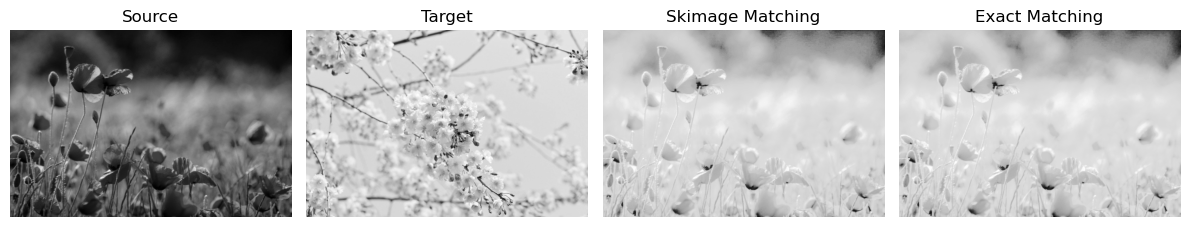

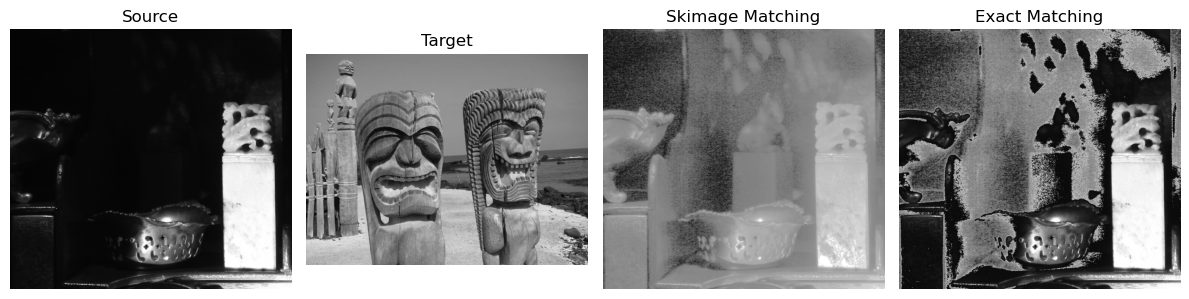

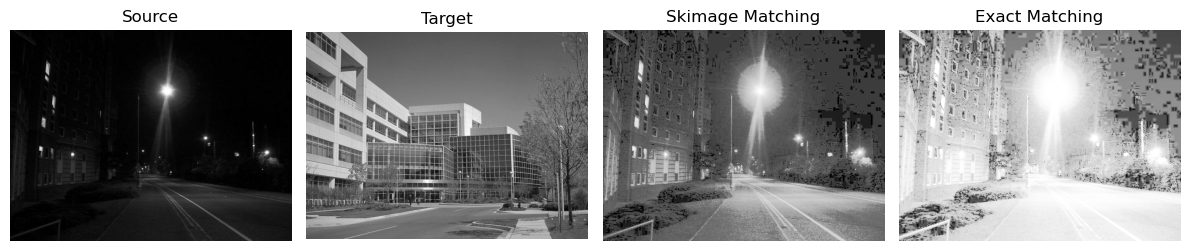

In [13]:
compare_algorithm_matching("images/poppies.png", "images/cherry_tree.png")
compare_algorithm_matching("images/hidden-horse.tif", "images/totem-poles.tif")
compare_algorithm_matching("images/road_low_2.jpg", "images/national-archives-bld.tif")

C:\Users\JeannotMunganga\AppData\Local\Temp\ipykernel_15864\3111346168.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cdf_3.set_yticklabels(cdf_3.get_yticklabels(), color='orange')


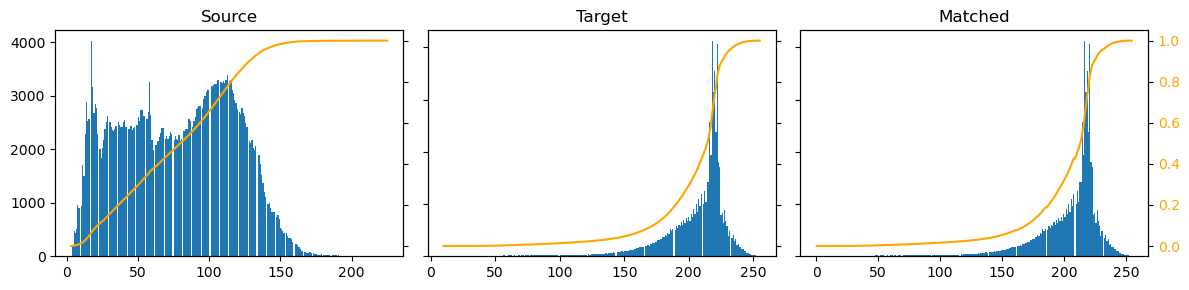

In [14]:
algorithm_analysis("images/poppies.png", "images/cherry_tree.png")

# Question 2. Frequency Domain Filtering

## 2.1 Butterworth filter band reject filter

### What is being implemented here?
A band reject filter is designed to remove a given range/band of frequency component from a given image.

### What are some output expectations
We are implementing a Butterworth Band Reject filter which is given by:
$H(u, v) =\frac{1}{{1 + \left(\frac{D \times W}{\text{D^2 - DO^2}}\right)^{2 \times n}}}$

Depending on the values of DO and W, we should a expect that:
>* the filter behaves like a high pass filter for very small D0 (such as 0)
>* the filter behaves like a low pass filter for bigger values of W and big/medium values of D0
>* Butterworth Band Reject other medium values of W and DO

 ### How was this implemented?
 For this problem we followed the following algorithm :
 >* Design a grid in the frequency domain
 >* We compute the distances with the center(0, 0) as a reference
 >* We design the filter using the above-mentioned expression
 >* Apply filtering and return result
 
### Were your output expectations met?
Yes, as seen with different tests run with various values of W and D0, the output behave exactly as described above and the algorithm was able to perform band rejecting.

We also noted that not padding the input image did not have any negative effect in this case, hence padding was omitted.

In [15]:
def butterworth_reject_band_filter(img, DO, W, n=2):
    np.seterr(divide='ignore', invalid='ignore')
    
    M, N = img.shape
    
    # Setup a mesh grid
    u = np.arange(0, M, 1)
    v = np.arange(0, N, 1)
    idx = np.where(u > M/2)
    idy = np.where(v > N/2)
    u[idx] -= M
    v[idy] -= N
    V, U = np.meshgrid(v, u)
    
    # Compute distance
    D = np.sqrt(U**2 + V**2)
    
    # We need to handle cases where the denominator is zero to keep the filter functional in all cases
    denominator = D**2 - DO**2
    denominator[denominator == 0] = np.inf
    
    # Design the filter
    filter = 1 / (1 + (D * W / denominator) ** (2 * n))
    
    # Apply filter on input and get the filtered image
    img_f_transform = fftpack.fft2(img)
    filtered_img = fftpack.ifft2(img_f_transform * filter).real
    
    # We want to return the shifted filter for visualisation
    filter_shift = fftpack.ifftshift(filter)
    
    return filtered_img, filter_shift

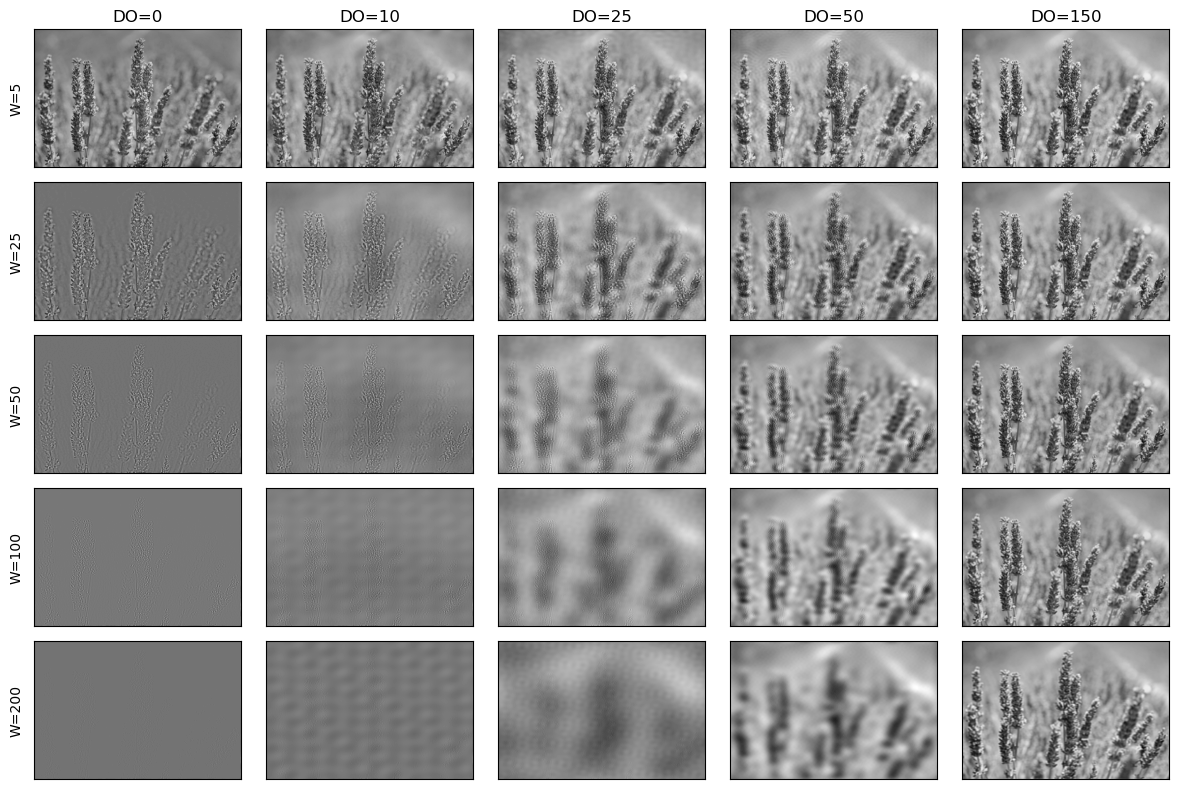

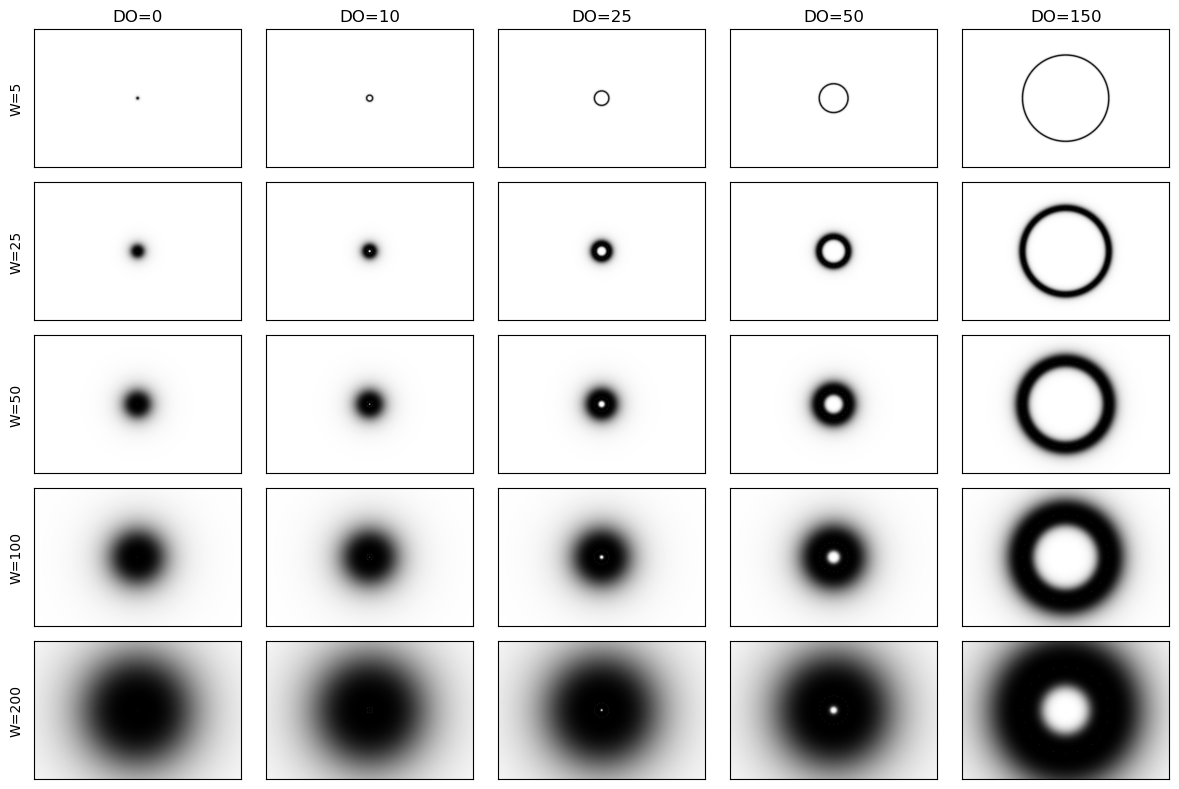

In [16]:
def plot_grid(img_grid):
    fig, axes = plt.subplots(img_grid.shape[0], img_grid.shape[1], figsize=(12, 8))
    DOs = [0, 10, 25, 50, 150]
    Ws = [5, 25, 50, 100, 200]
    
    for r in range(img_grid.shape[0]):
        for c in range(img_grid.shape[1]):
            axes[r, c].imshow(img_grid[r, c], cmap='gray')
            axes[r, c].set_yticklabels([])
            axes[r, c].set_xticklabels([])
            axes[r, c].tick_params(axis=u'both', which=u'both',length=0)
            if r == 0:    
                axes[r, c].set_title("DO=" + str(DOs[c]))
            if c == 0:
                axes[r, c].set_ylabel("W=" + str(Ws[r]))
    plt.tight_layout()    

lavender = io.imread("images/lavender.png")
DOs = [0, 10, 25, 50, 150]
Ws = [5, 25, 50, 100, 200]

# Filtered Images and Filters are setup in a grid of images, i.e. A 5x5 grid of 2D images, a total of 4 dimensions
filtered_images = np.empty((len(Ws), len(DOs),lavender.shape[0], lavender.shape[1]))
filters = np.empty((len(Ws), len(DOs),lavender.shape[0], lavender.shape[1]))

# We get filtered_images as well as the filter used for each
for r in range(len(Ws)):
    for c in range(len(DOs)):
        filtered_images[r,c], filters[r,c] = butterworth_reject_band_filter(lavender, DOs[c], Ws[r])
        
plot_grid(filtered_images)
plot_grid(filters)

## 2.2 Notch Filtering

### What is being implemented here?
We are trying to remove moire patterns from an image using notch filters

### What are some output expectations
We are expecting to be given an image with moire pattern, after applying a certain designed filter the image should be cleared of these patterns

 ### How was this implemented?
 For this problem we followed the following algorithm :
 >* Get the input image and show its spectrum, this helped in identifying what the location of each notch should be
 >* Using the locations identified above we create a notch reject filter for each of those
 >* We combine the above created notch reject filters to create a final filter
 >* Apply filtering on input image using the combination of the notch filter and return result
 
### Were your output expectations met?
Yes, we were able to get the image spectrum to indentify what should be the location of each of our notch, filters we designed and combined to achieve the notch removal

We also noted that not padding the input image did not have any negative effect in this case, hence padding was omitted.

A combination of different type of filter was also test and their respective results can be seen below.

In [9]:
def notch_reject_filter(img_size, center_pos=(0, 0), DO=10, filter_type='butterworth'):
    M, N = img_size
    
    # First We generate a mesh grid
    u = np.arange(0, M, 1)
    v = np.arange(0, N, 1)
    idx = np.where(u > M/2)
    idy = np.where(v > N/2)
    u[idx] -= M
    v[idy] -= N
    V, U = np.meshgrid(v, u)

    # Compute the distances
    uk, vk = center_pos
    Dpos_k = np.sqrt((U - M/2 - uk)**2 + (V - N/2 - vk)** 2)
    Dneg_k = np.sqrt((U - M/2 + uk)** 2 + (V - N/2 + vk)** 2)
    
    # Setup and return the filter depending on the desired type
    if filter_type == 'ideal':
        id_pos_k = np.where(Dpos_k > DO)
        id_neg_k = np.where(Dneg_k > DO)
        
        Hpos_k = np.zeros((M,N))
        Hneg_k = np.zeros((M,N))
        
        Hpos_k[id_pos_k] = 1
        Hneg_k[id_neg_k] = 1
        
        return Hpos_k * Hneg_k
    
    if filter_type == 'gaussian':
        Hpos_k = 1 - np.exp(-(Dpos_k **2) / (2 * DO**2) )
        Hneg_k = 1 - np.exp(-(Dneg_k **2) / (2 * DO**2) )
        
        return Hneg_k * Hpos_k
    
    Hpos_k = 1 / (1 + (DO / Dpos_k)**2)
    Hneg_k = 1 / (1 + (DO / Dneg_k)**2)
    return Hneg_k * Hpos_k

In [18]:
def moire_removal_demo(filter_type=None, random_filter_type=False):
    moire_car_img = io.imread("images/car_75DPI_Moire.tif")
    img_shape = moire_car_img.shape
    
    f_transform = fftpack.fft2(moire_car_img)
    input_spectrum = 20 * np.log(np.abs(f_transform))
    
    _filters = ['ideal','gaussian','butterworth']
    H1 = notch_reject_filter(img_shape, (40, 55), 5, filter_type= random.choice(_filters) if random_filter_type else filter_type)
    H2 = notch_reject_filter(img_shape, (40, 110), 5, filter_type=random.choice(_filters) if random_filter_type else filter_type)
    H3 = notch_reject_filter(img_shape, (80, 55), filter_type=random.choice(_filters) if random_filter_type else filter_type)
    H4 = notch_reject_filter(img_shape, (80, 110), filter_type=random.choice(_filters) if random_filter_type else filter_type)
    H5 = notch_reject_filter(img_shape, (165, 57), filter_type=random.choice(_filters) if random_filter_type else filter_type)
    H6 = notch_reject_filter(img_shape, (160, 113), filter_type=random.choice(_filters) if random_filter_type else filter_type)
    H7 = notch_reject_filter(img_shape, (205, 57),5, filter_type=random.choice(_filters) if random_filter_type else filter_type)
    H8 = notch_reject_filter(img_shape, (200, 113),5, filter_type=random.choice(_filters) if random_filter_type else filter_type)
    filter = H1 * H2 * H3 * H4 * H5 * H6 * H7 * H8
    
    filtering_result = f_transform * filter
    filtering_result_img = np.real(fftpack.ifft2(filtering_result))
    
    fig, axes = plt.subplots(2,2, figsize=(8,8))
    axes[0,0].imshow(moire_car_img, cmap='gray')
    axes[0,0].set_title('Input Image')
    axes[0,0].axis('off')
    
    axes[0,1].imshow(fftpack.fftshift(input_spectrum), cmap='gray')
    axes[0,1].set_title('Input Image Spectrum')
    axes[0,1].axis('off')
    
    axes[1,0].imshow(fftpack.ifftshift(filter), cmap='gray')
    axes[1,0].set_title('Filter')
    axes[1,0].axis('off')
    
    axes[1,1].imshow(filtering_result_img, cmap='gray')
    axes[1,1].set_title('Output Image')
    axes[1,1].axis('off')
    plt.tight_layout()
    plt.imshow(filtering_result_img, cmap='gray')

### Test moire removal using butterworth filters

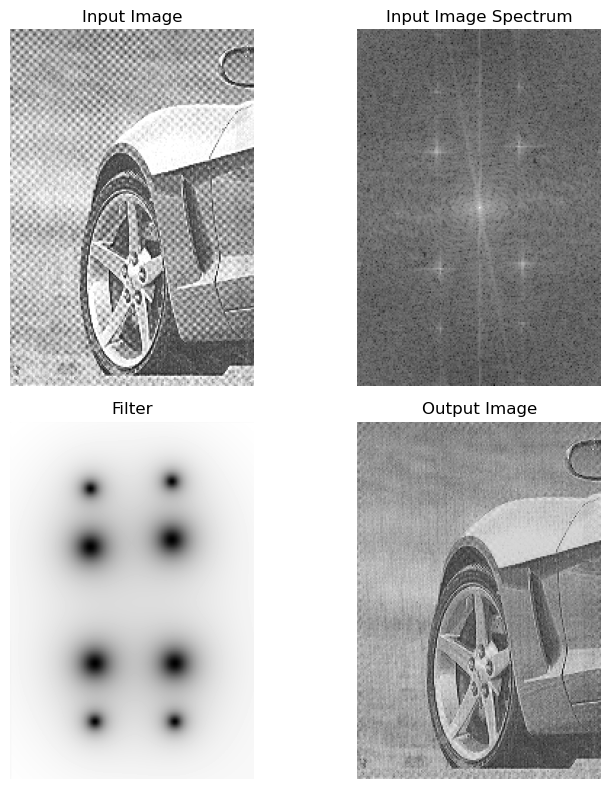

In [19]:
moire_removal_demo('butterworth')

### Test moire removal using Gaussian filters

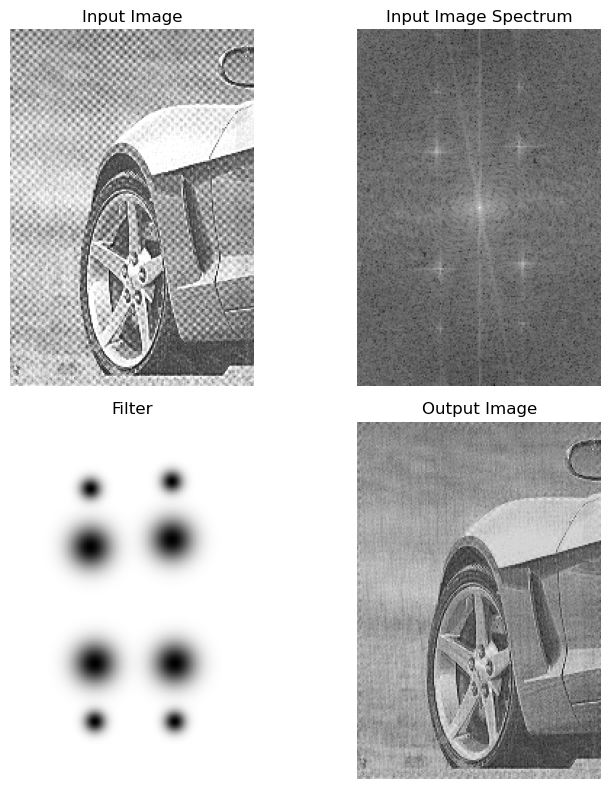

In [20]:
moire_removal_demo('gaussian')

### Test moire removal using Ideal filters

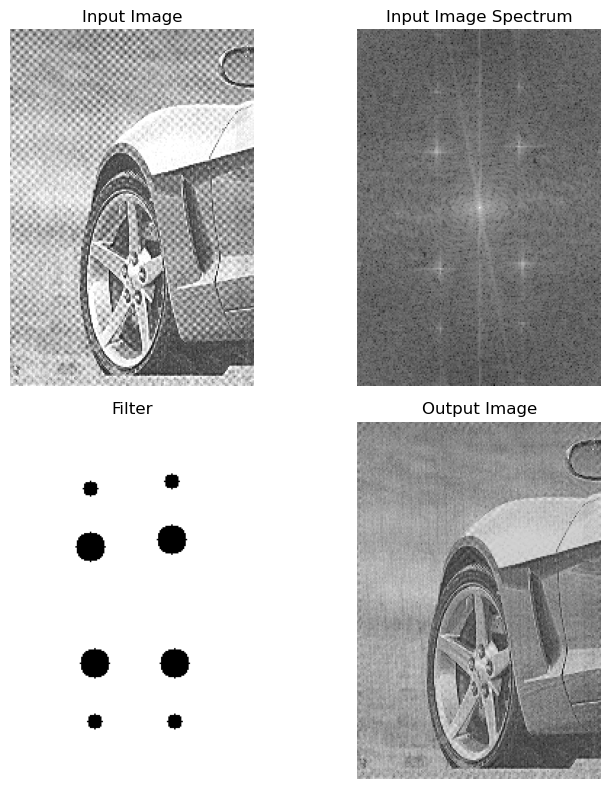

In [21]:
moire_removal_demo('ideal')

### What about mixing different type of filters randomly :-)

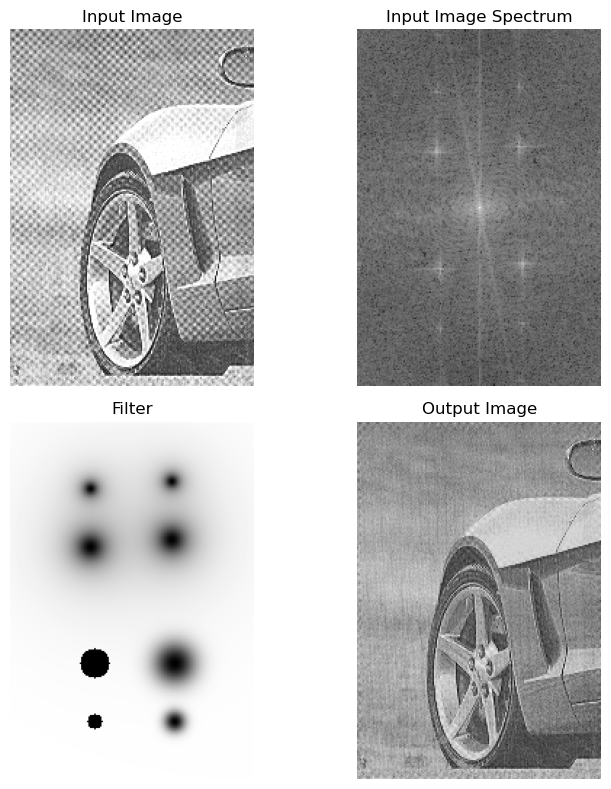

In [22]:
moire_removal_demo(random_filter_type=True)

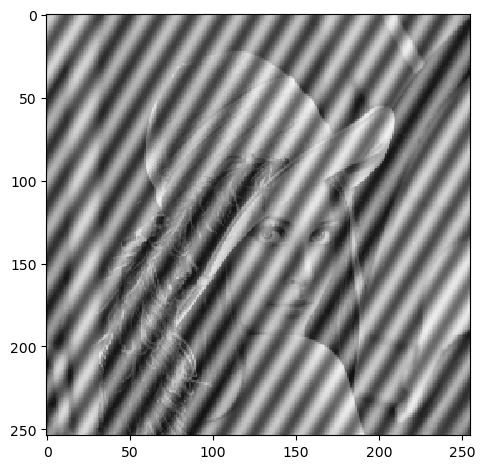

In [5]:
noisy_lena = io.imread("images/noisy_lena.png", as_gray=True)
io.imshow(noisy_lena, cmap='gray')

(254, 255)

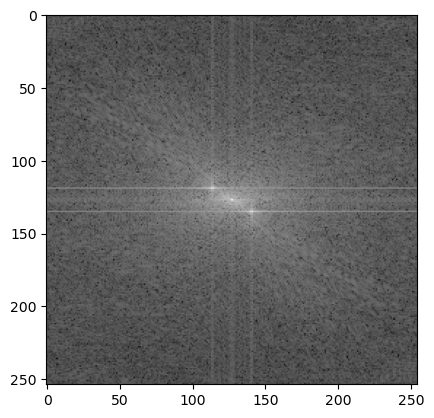

In [10]:
f_noisy_lena = fftpack.fft2(noisy_lena)
spec_noisy_lena = np.abs(f_noisy_lena)

plt.imshow(fftpack.fftshift(20 * np.log(spec_noisy_lena)), cmap='gray')


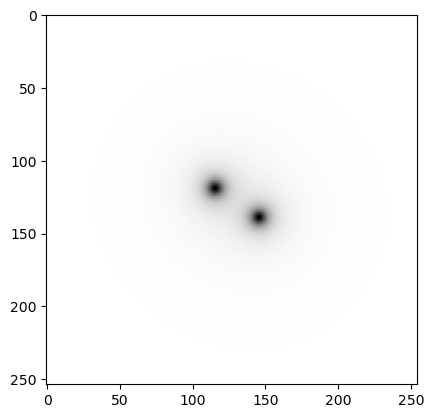

In [27]:
H1 = notch_reject_filter(noisy_lena.shape, (115, 110), 5)
H2 = notch_reject_filter(noisy_lena.shape, (135, 140), 5)

filter = H1 * H2

plt.imshow(fftpack.ifftshift(filter), cmap='gray')

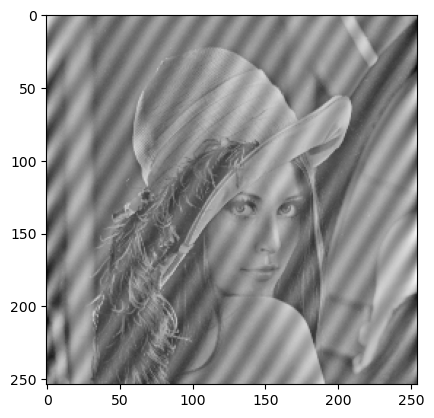

In [28]:
filtering_result = f_noisy_lena * filter
filtering_result_img = np.real(fftpack.ifft2(filtering_result))

plt.imshow(filtering_result_img, cmap='gray')

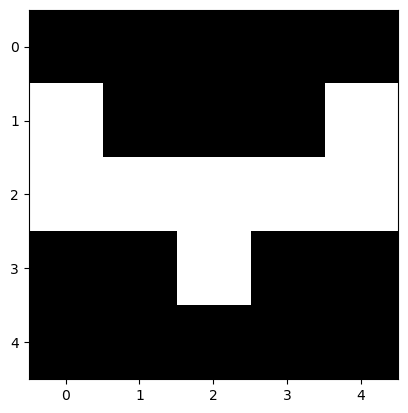

In [45]:
img = np.zeros((5,5), np.int16)

img[1, 0] = 255
img[1, 4] = 255
img[2, 0] = 255
img[2, 1] = 255
img[2, 2] = 255
img[2, 3] = 255
img[2, 4] = 255
img[3, 2] = 255

plt.imshow(img, cmap='gray')

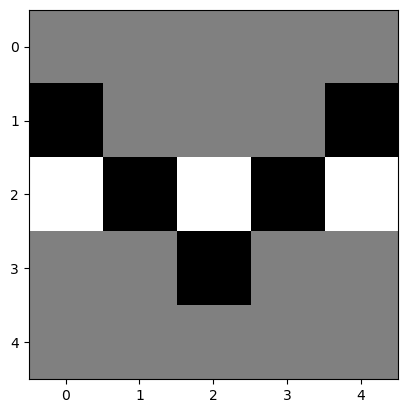

In [38]:
for x in range(img.shape[0]):
    for y in range(img.shape[1]):
        img[x, y] *= np.power(-1, x+y)

plt.imshow(img, cmap='gray')

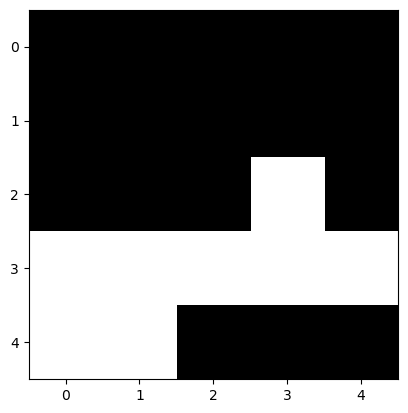

In [41]:
img_f = fftpack.fft2(img)
img_f_conj = np.conj(img_f)

img_conj_r = np.real(fftpack.ifft2(img_f_conj))
# 
# for x in range(img_conj_r.shape[0]):
#     for y in range(img_conj_r.shape[1]):
#         img_conj_r[x, y] *= np.power(-1, x+y)

plt.imshow(img_conj_r, cmap='gray')

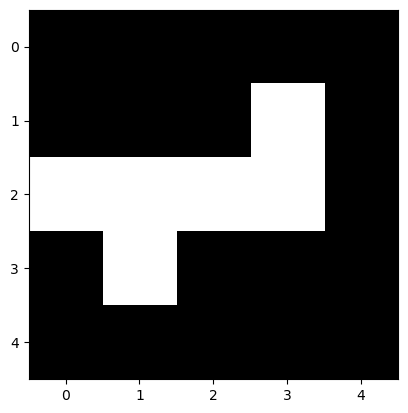

In [46]:
img = convolve2d(img, np.array([[0,0,0], [1,0,0], [0,0,0]]), mode='same')
plt.imshow(img, cmap='gray')